## Libraries & Installations

In [ ]:
!pip install -q peft bitsandbytes
!git clone https://github.com/facebookresearch/segment-anything-2.git

%cd segment-anything-2
!pip install -e . -q

!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt

%cd ..

print("Environment setup complete. SAM 2 installed and weights downloaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

## Libraries

In [ ]:
import sys
sys.path.append("/kaggle/working/segment-anything-2")
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from peft import get_peft_model, LoraConfig

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-12-19 00:42:47.995422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766104968.187190      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766104968.243834      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


## Loading Models

In [ ]:
def load_sam2_peft_model(finetuned_ckpt=None):
    sam2_repo_path = "./segment-anything-2"
    base_weights = os.path.join(sam2_repo_path, "sam2_hiera_small.pt")
    config = "sam2_hiera_s.yaml"
    
    print("Building Base SAM 2...")
    model = build_sam2(config, base_weights, device=device)
    
    if finetuned_ckpt:
        print(f"Loading PEFT Weights from {finetuned_ckpt}...")
        
        target_modules = []
        for name, module in model.sam_mask_decoder.named_modules():
            if isinstance(module, torch.nn.Linear):
                # PEFT expects the full path relative to the model root
                full_name = f"sam_mask_decoder.{name}"
                target_modules.append(full_name)
        
        peft_config = LoraConfig(
            r=8,
            lora_alpha=16,
            target_modules=target_modules,
            lora_dropout=0.05,
            bias="none",
            task_type=None, 
        )

        model = get_peft_model(model, peft_config)
        
        checkpoint = torch.load(finetuned_ckpt, map_location=device)
        
        try:
            model.load_state_dict(checkpoint)
            print("PEFT weights loaded successfully.")
        except RuntimeError as e:
            print(f"Standard load failed: {e}")
            print("Attempting strict=False load...")
            model.load_state_dict(checkpoint, strict=False)

        # SAM2ImagePredictor expects a standard SAM 2 object, not a PeftModel wrapper.
        # This folds the LoRA weights into the base layers and removes the wrapper.
        model = model.merge_and_unload()
        print("LoRA weights merged into base model for inference.")

    else:
        print("Using Zero-shot Base Model.")

    model.to(device)
    model.eval()
    return SAM2ImagePredictor(model)
    
SAM2_FINETUNED_PATH = "/kaggle/input/sam-2-lora-adapter-viton-hd/sam2_finetuned (2).pth"

# Base SAM 2
sam2_base = load_sam2_peft_model(finetuned_ckpt=None)

# Fine-tuned SAM 2
sam2_ft = load_sam2_peft_model(SAM2_FINETUNED_PATH)

Building Base SAM 2...
Using Zero-shot Base Model.
Building Base SAM 2...
Loading PEFT Weights from /kaggle/input/sam-2-lora-adapter-viton-hd/sam2_finetuned (2).pth...
PEFT weights loaded successfully.
LoRA weights merged into base model for inference.


## Dataset

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

ROOT_DIR = "/kaggle/input/high-resolution-viton-zalando-dataset"
MASK_DIR = os.path.join(ROOT_DIR, 'test', 'image-parse-v3')
if not os.path.exists(MASK_DIR):
    MASK_DIR = os.path.join(ROOT_DIR, 'test', 'image-parse')

def detect_shirt_color(mask_dir):
    # Get first image
    files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))])
    first_mask_path = os.path.join(mask_dir, files[0])
    
    # Load and find unique colors
    mask = cv2.imread(first_mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    pixels = mask.reshape(-1, 3)
    colors, counts = np.unique(pixels, axis=0, return_counts=True)
    
    # Sort by frequency
    sorted_indices = np.argsort(-counts)
    sorted_colors = colors[sorted_indices]
    
    # Rank 0 is background. Rank 1 is Shirt
    shirt_color = sorted_colors[1]
    
    print(f"Auto-Detected Shirt Color (RGB): {shirt_color}")
    return shirt_color

# Detect and Store
TARGET_RGB = detect_shirt_color(MASK_DIR)

Auto-Detected Shirt Color (RGB): [254  85   0]


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class VITONEvalDataset(Dataset):
    def __init__(self, root_dir, target_rgb, transform=None):
        self.root_dir = root_dir
        self.target_rgb = target_rgb
        self.image_dir = os.path.join(root_dir, 'test', 'image')
        self.transform = transform
        
        mask_candidates = ['test/image-parse-v3', 'test/image-parse']
        self.mask_dir = None
        for c in mask_candidates:
            if os.path.exists(os.path.join(root_dir, c)):
                self.mask_dir = os.path.join(root_dir, c)
                break
        
        # Index pairs
        self.data_pairs = []
        for f in sorted(os.listdir(self.image_dir)):
            if f.endswith(('.jpg', '.png')):
                base = os.path.splitext(f)[0]
                # Find corresponding mask
                for ext in ['.png', '.jpg', '_label.png']:
                    m_path = os.path.join(self.mask_dir, base + ext)
                    if os.path.exists(m_path):
                        self.data_pairs.append((f, m_path))
                        break

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_name, mask_path = self.data_pairs[idx]
        
        # Load Image
        image = cv2.imread(os.path.join(self.image_dir, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load Mask
        mask_rgb = cv2.imread(mask_path)
        mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
        
        # Pixels matching TARGET_RGB = 1, others = 0
        # Allow small tolerance for JPEG compression noise
        diff = np.abs(mask_rgb.astype(int) - self.target_rgb.astype(int))
        binary_mask = (np.sum(diff, axis=-1) < 15).astype(np.uint8)
        
        # Transform for HRNet
        if self.transform:
            tensor_img = self.transform(image)
        else:
            tensor_img = image

        return {
            "image": image,
            "tensor": tensor_img,
            "mask": binary_mask,
            "name": img_name
        }
# Evaluation Transforms
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = VITONEvalDataset(ROOT_DIR, TARGET_RGB, transform=eval_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
print("Test images: ", len(dataset))

Test images:  2032


## Evaluation

Starting Evaluation (Upper Clothes Only)...


  0%|          | 0/254 [00:00<?, ?it/s]

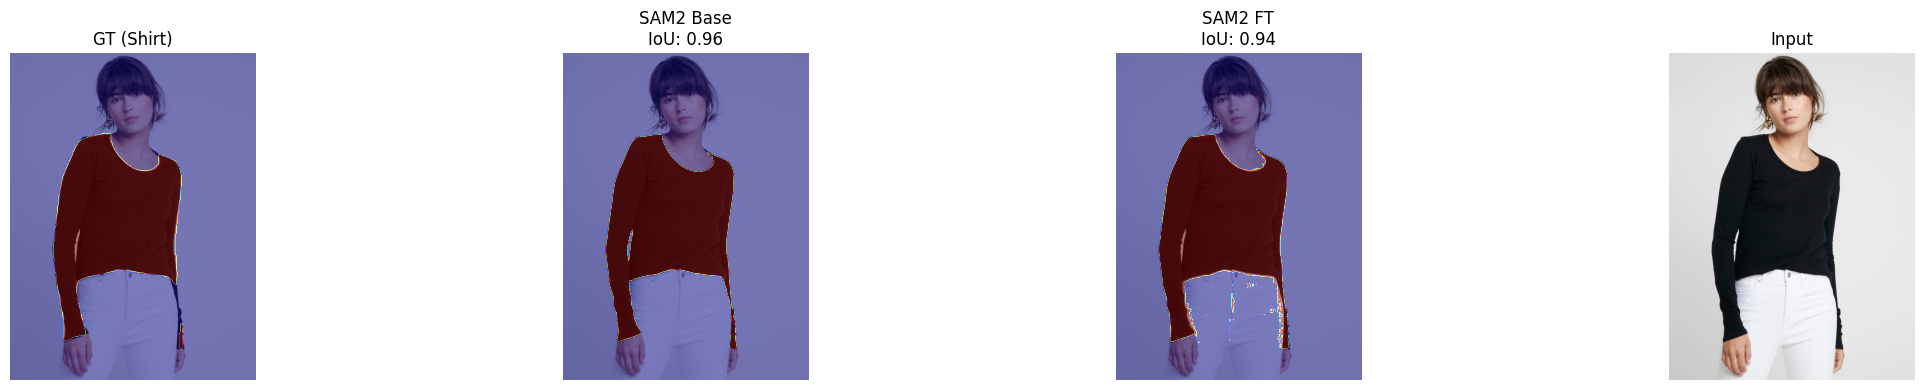

  0%|          | 1/254 [00:02<11:21,  2.70s/it]

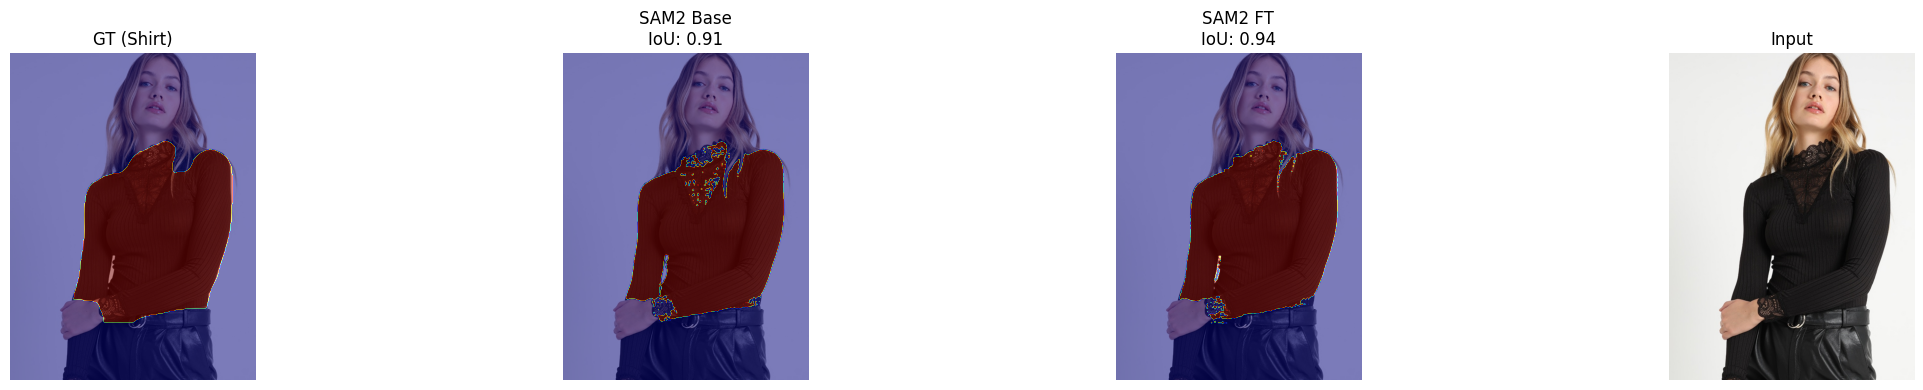

  1%|          | 2/254 [00:04<08:47,  2.09s/it]

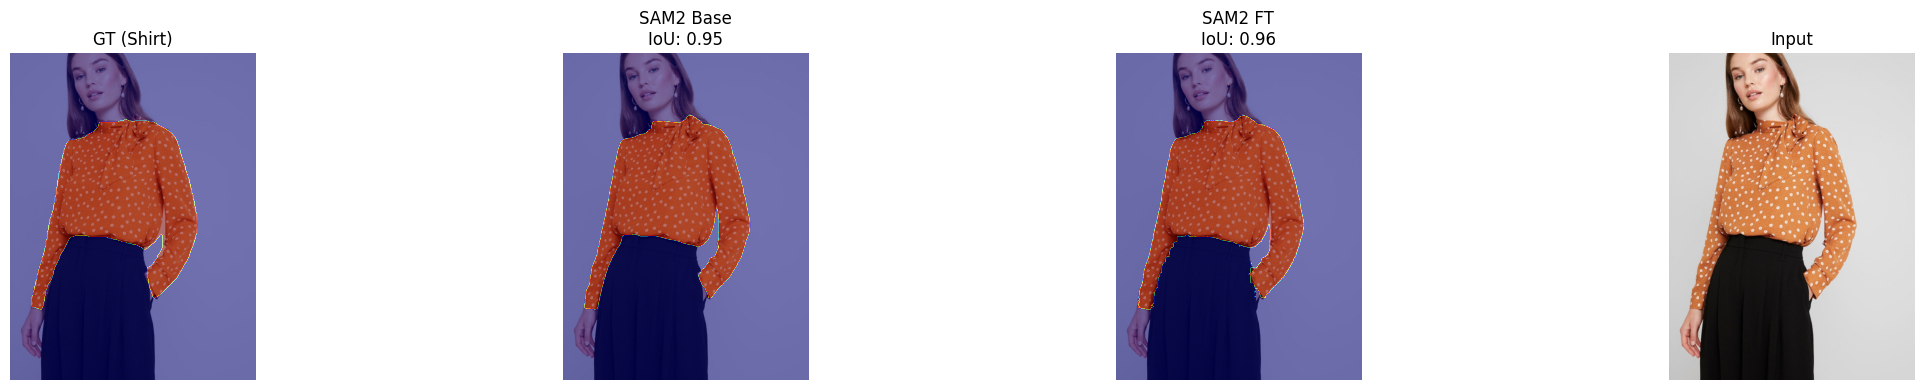

  2%|▏         | 4/254 [00:06<05:40,  1.36s/it]

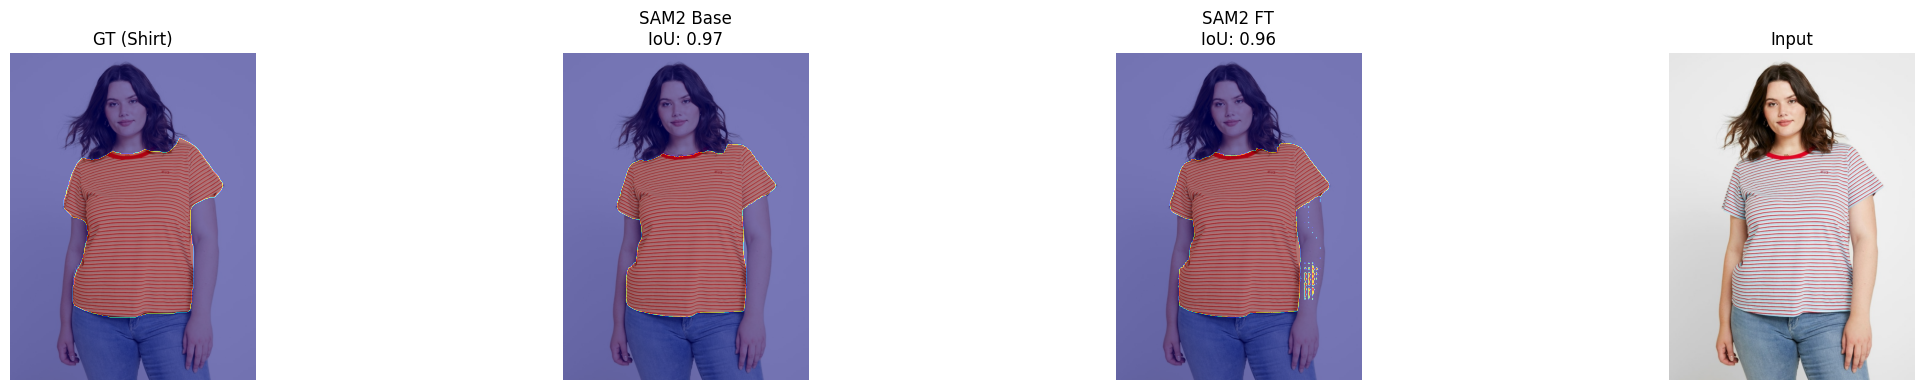

  2%|▏         | 5/254 [00:08<06:18,  1.52s/it]

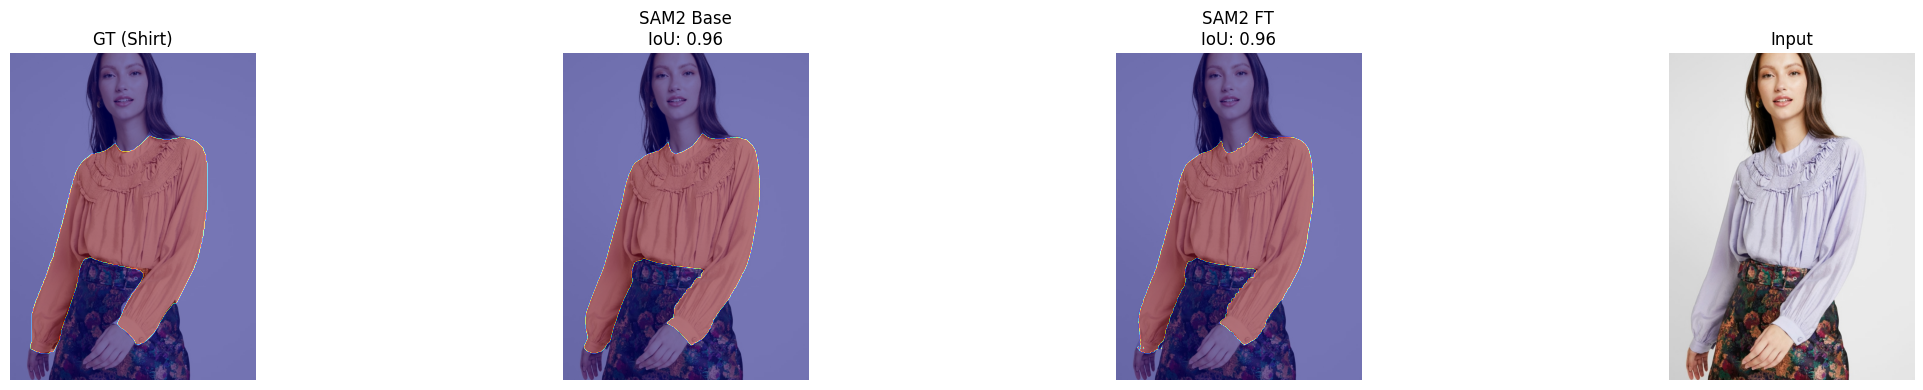

100%|██████████| 254/254 [03:42<00:00,  1.14it/s]


=== Final Results (Upper Clothes) ===
FT IoU: 0.9158
Base IoU: 0.9237


In [ ]:
def compute_iou(pred_mask, gt_mask):
    pred_mask = pred_mask.flatten()
    gt_mask = gt_mask.flatten()
    
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    
    if union == 0:
        return 0.0 if intersection == 0 else 0.0
    return intersection / union

metrics = {
    "FT": [], "Base": [],
}

vis_count = 0
MAX_VIS = 5

print("Starting Evaluation (Upper Clothes Only)...")

for batch in tqdm(dataloader):
    img_tensor = batch['tensor'].to(device)
    original_img = batch['image'][0].numpy()
    gt_mask = batch['mask'][0].numpy()
    
    if gt_mask.sum() == 0:
        continue

    # We use the bounding box of the shirt as a prompt
    y_indices, x_indices = np.where(gt_mask > 0)
    if len(x_indices) > 0:
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        box_prompt = np.array([x_min, y_min, x_max, y_max])
    else:
        # Fallback to full image
        h, w = gt_mask.shape
        box_prompt = np.array([0, 0, w, h])

    # SAM 2 Base
    sam2_base.set_image(original_img)
    masks, _, _ = sam2_base.predict(box=box_prompt[None, :], multimask_output=False)
    mask_sam2_base = masks[0].astype(np.uint8)
    metrics["Base"].append(compute_iou(mask_sam2_base, gt_mask))

    # SAM 2 Fine-Tuned
    sam2_ft.set_image(original_img)
    masks, _, _ = sam2_ft.predict(box=box_prompt[None, :], multimask_output=False)
    mask_sam2_ft = masks[0].astype(np.uint8)
    metrics["FT"].append(compute_iou(mask_sam2_ft, gt_mask))

    # Visualization
    if vis_count < MAX_VIS:
        fig, axs = plt.subplots(1, 4, figsize=(24, 4))
        
        # Ground Truth
        axs[0].imshow(original_img)
        axs[0].imshow(gt_mask, cmap='jet', alpha=0.5)
        axs[0].set_title("GT (Shirt)")
        axs[0].axis('off')
        
        # Models
        titles = ["SAM2 Base", "SAM2 FT"]
        preds = [ metrics["Base"][-1], metrics["FT"][-1]]
        imgs = [mask_sam2_base, mask_sam2_ft]
        
        viz_masks = [
            mask_sam2_base,
            mask_sam2_ft
        ]
        
        for i, (m, t, score) in enumerate(zip(viz_masks, titles, preds)):
            axs[i+1].imshow(original_img)
            # Resize HRNet outputs for viz if needed
            if m.shape != gt_mask.shape:
                m = cv2.resize(m.astype(float), (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
            axs[i+1].imshow(m, cmap='jet', alpha=0.5)
            axs[i+1].set_title(f"{t}\nIoU: {score:.2f}")
            axs[i+1].axis('off')
            
        axs[3].imshow(original_img)
        axs[3].set_title("Input")
        axs[3].axis('off')
        
        plt.tight_layout()
        plt.show()
        vis_count += 1

print("\n=== Final Results (Upper Clothes) ===")
for k, v in metrics.items():
    print(f"{k} IoU: {np.mean(v):.4f}")